In [ ]:
!pip install --upgrade mxnet
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install --upgrade gluoncv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matplotlib import pyplot as plt 
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord_alpha_pose
import mxnet as mx
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
from PIL import Image
import glob

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.6.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('alpha_pose_resnet101_v1b_coco', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

In [ ]:
def load_file(file_loc:str):
  if not os.path.exists(file_loc):
    print(f"File not found in {file_loc}")

  cap = cv2.VideoCapture(file_loc)
  frames = []
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")
  
  # Read until video is completed
  while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      frames.append(frame)
    else: 
      break
  
  # When everything done, release the video capture object
  cap.release()
  
  # Closes all the frames
  cv2.destroyAllWindows()
  return frames

def save_arrays_file(frame_ids,skeletal_frames,confidence_frames,location):
  frame_ids = np.array(frame_ids)
  skeletal_frames = np.array([a.asnumpy() for a in skeletal_frames])
  confidence_frames = np.array([a.asnumpy() for a in confidence_frames])

  print(frame_ids.shape,skeletal_frames.shape,confidence_frames.shape)
  np.savez(location,frame_ids=frame_ids,coords=skeletal_frames,confidences=confidence_frames)

def run_human_track(frames,human_detector,pose_estimator):
  frames = [mx.ndarray.array(a) for a in frames]
  
  final_frames = []
  confidence_frames = []
  skeletal_frames = []
  frame_ids = []
  for __id,frame in tqdm(enumerate(frames)):
    x, img = data.transforms.presets.yolo.transform_test(frame, short=512)
    class_IDs, scores, bounding_boxs = human_detector(x)
    pose_input, upscale_bbox = detector_to_alpha_pose(img, class_IDs, scores, bounding_boxs)
    try:
      predicted_heatmap = pose_estimator(pose_input)
      pred_coords, confidence = heatmap_to_coord_alpha_pose(predicted_heatmap, upscale_bbox)
      final_frames.append(img)
      confidence_frames.append(confidence)
      skeletal_frames.append(pred_coords)
      frame_ids.append(__id)
    except:
      pass
  return final_frames,skeletal_frames,frame_ids, confidence_frames

def plot_skeleton_keypoints(img_shape, coords, confidence, keypoint_thresh=0.2, **kwargs):
    """Visualize keypoints.
    """
    import matplotlib.pyplot as plt

    if isinstance(coords, mx.nd.NDArray):
        coords = coords.asnumpy()
    if isinstance(confidence, mx.nd.NDArray):
        confidence = confidence.asnumpy()

    joint_visible = confidence[:, :, 0] > keypoint_thresh
    joint_pairs = [[0, 1], [1, 3], [0, 2], [2, 4],
                   [5, 6], [5, 7], [7, 9], [6, 8], [8, 10],
                   [5, 11], [6, 12], [11, 12],
                   [11, 13], [12, 14], [13, 15], [14, 16]]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.zeros(img_shape).astype(np.uint8))
    colormap_index = np.linspace(0, 1, len(joint_pairs))
    for i in range(coords.shape[0]):
        pts = coords[i]
        for cm_ind, jp in zip(colormap_index, joint_pairs):
            if joint_visible[i, jp[0]] and joint_visible[i, jp[1]]:
                ax.plot(pts[jp, 0], pts[jp, 1],
                        linewidth=3.0, alpha=0.7, color=plt.cm.cool(cm_ind))
                ax.scatter(pts[jp, 0], pts[jp, 1], s=20)
    return ax,fig

def save_video_skeleton(final_frames,skeletal_frames,frame_ids,confidence_frames,file_name):
  os.makedirs(f"temp/{file_name}",exist_ok=True)
  for frame,sk_frame,frame_id,confidence in zip(final_frames,skeletal_frames,frame_ids,confidence_frames):
    axe, fig = plot_skeleton_keypoints(frame.shape, sk_frame, confidence, keypoint_thresh=0.2)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = data.astype(np.uint8)
    cv2.imwrite(f"temp/{file_name}/{frame_id}.png",img)
    plt.close(fig)

  return f"temp/{file_name}"
def int_val_filename(file_name):
  return int(file_name.split("/")[-1].split(".")[0])

def convert_to_video(images_path,save_path):
  img_array = []
  file_names = [filename for filename in glob.glob(f"{images_path}/*.png")]
  file_names.sort(key=int_val_filename)
  print(file_names)
  

  for filename in file_names:
      img = cv2.imread(filename)
      height, width, layers = img.shape
      size = (width,height)
      img_array.append(img)


  out = cv2.VideoWriter(save_path,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
  
  for i in range(len(img_array)):
      out.write(img_array[i])
  out.release()
  shutil.rmtree(images_path)

  



    




In [ ]:
frames = load_file("/content/Veoh_Alpha_Dog_2_run_f_nm_np1_fr_med_26.avi")
final_frames,skeletal_frames,frame_ids,confidence_frames = run_human_track(frames,detector,pose_net)
save_arrays_file(frame_ids,skeletal_frames,confidence_frames,"out.npz")
image_paths = save_video_skeleton(final_frames,skeletal_frames,frame_ids,confidence_frames,"outvid")
convert_to_video(image_paths,"output_video.avi")

137it [03:06,  1.36s/it]


(122,) (122, 1, 17, 2) (122, 1, 17, 1)
['temp/outvid/11.png', 'temp/outvid/12.png', 'temp/outvid/13.png', 'temp/outvid/17.png', 'temp/outvid/18.png', 'temp/outvid/19.png', 'temp/outvid/20.png', 'temp/outvid/21.png', 'temp/outvid/23.png', 'temp/outvid/24.png', 'temp/outvid/25.png', 'temp/outvid/26.png', 'temp/outvid/27.png', 'temp/outvid/28.png', 'temp/outvid/29.png', 'temp/outvid/30.png', 'temp/outvid/31.png', 'temp/outvid/32.png', 'temp/outvid/33.png', 'temp/outvid/34.png', 'temp/outvid/35.png', 'temp/outvid/36.png', 'temp/outvid/37.png', 'temp/outvid/38.png', 'temp/outvid/39.png', 'temp/outvid/40.png', 'temp/outvid/41.png', 'temp/outvid/42.png', 'temp/outvid/43.png', 'temp/outvid/44.png', 'temp/outvid/45.png', 'temp/outvid/46.png', 'temp/outvid/47.png', 'temp/outvid/48.png', 'temp/outvid/49.png', 'temp/outvid/50.png', 'temp/outvid/51.png', 'temp/outvid/52.png', 'temp/outvid/53.png', 'temp/outvid/54.png', 'temp/outvid/55.png', 'temp/outvid/56.png', 'temp/outvid/57.png', 'temp/outvid/5

In [ ]:
npzfile = np.load("out.npz")
sorted(npzfile.files)
npzfile["coords"].shape,npzfile["frame_ids"]

((122, 1, 17, 2),
 array([ 11,  12,  13,  17,  18,  19,  20,  21,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136]))

In [ ]:
set_of_classes = [os.listdir("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/hand_picked_videos")]
set_of_classes = ["ride_bike","going_down_stairs","going_up_stairs", "walk","run","sitting_down","vacuum_cleaning"]
for class_type in set_of_classes:
  class_loc = os.path.join("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/hand_picked_videos",class_type)
  save_fol = os.path.join("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/skeleton_vids",class_type)
  save_numpy_fol = os.path.join("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/skeleton_out",class_type)
  os.makedirs(save_fol,exist_ok=True)
  os.makedirs(save_numpy_fol,exist_ok=True)
  video_list = os.listdir(class_loc)

  for vid in tqdm(video_list):
    video_id = vid.split(".")[0]
    if not os.path.exists(os.path.join(save_fol,f"{video_id}.avi")):
      try:
        frames = load_file(os.path.join(class_loc,vid))
        final_frames,skeletal_frames,frame_ids,confidence_frames = run_human_track(frames,detector,pose_net)
        save_arrays_file(frame_ids,skeletal_frames,confidence_frames,os.path.join(save_numpy_fol,f"{video_id}.npz"))
        image_paths = save_video_skeleton(final_frames,skeletal_frames,frame_ids,confidence_frames,video_id)
        convert_to_video(image_paths,os.path.join(save_fol,f"{video_id}.avi"))
      except:
        print(f"error in {class_type} video :- {video_id}")
    else:
      print(f'{os.path.join(save_fol,f"{video_id}.avi")} path exists !')

  0%|          | 0/886 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.37s/it]
2it [00:04,  2.07s/it]
3it [00:06,  1.96s/it]
4it [00:07,  1.89s/it]
5it [00:09,  1.87s/it]
6it [00:11,  1.84s/it]
7it [00:13,  1.84s/it]
8it [00:15,  1.83s/it]
9it [00:16,  1.84s/it]
10it [00:18,  1.84s/it]
11it [00:20,  1.85s/it]
12it [00:22,  1.85s/it]
13it [00:24,  1.85s/it]
14it [00:26,  1.84s/it]
15it [00:28,  1.84s/it]
16it [00:29,  1.83s/it]
17it [00:31,  1.87s/it]
18it [00:33,  1.67s/it]
19it [00:34,  1.53s/it]
20it [00:36,  1.61s/it]
21it [00:37,  1.68s/it]
22it [00:39,  1.72s/it]
23it [00:41,  1.78s/it]
24it [00:43,  1.79s/it]
25it [00:44,  1.62s/it]
26it [00:45,  1.50s/it]
27it [00:47,  1.42s/it]
28it [00:48,  1.35s/it]
29it [00:49,  1.31s/it]
30it [00:50,  1.28s/it]
31it [00:51,  1.27s/it]
32it [00:53,  1.43s/it]
33it [00:55,  1.64s/it]
34it [00:57,  1.68s/it]
35it [00:59,  1.61s/it]
36it [01:00,  1.48s/it]
37it [01:02,  1.61s/it]
38it [01:03,  1.48s/it]
39it [01:04,  1.40s/it]
40it [01:05,  

(158,) (158, 1, 17, 2) (158, 1, 17, 1)
['temp/a109-0296C/0.png', 'temp/a109-0296C/1.png', 'temp/a109-0296C/2.png', 'temp/a109-0296C/3.png', 'temp/a109-0296C/4.png', 'temp/a109-0296C/5.png', 'temp/a109-0296C/6.png', 'temp/a109-0296C/7.png', 'temp/a109-0296C/8.png', 'temp/a109-0296C/9.png', 'temp/a109-0296C/10.png', 'temp/a109-0296C/11.png', 'temp/a109-0296C/12.png', 'temp/a109-0296C/13.png', 'temp/a109-0296C/14.png', 'temp/a109-0296C/15.png', 'temp/a109-0296C/16.png', 'temp/a109-0296C/19.png', 'temp/a109-0296C/20.png', 'temp/a109-0296C/21.png', 'temp/a109-0296C/22.png', 'temp/a109-0296C/23.png', 'temp/a109-0296C/31.png', 'temp/a109-0296C/32.png', 'temp/a109-0296C/36.png', 'temp/a109-0296C/40.png', 'temp/a109-0296C/43.png', 'temp/a109-0296C/44.png', 'temp/a109-0296C/45.png', 'temp/a109-0296C/46.png', 'temp/a109-0296C/47.png', 'temp/a109-0296C/50.png', 'temp/a109-0296C/51.png', 'temp/a109-0296C/52.png', 'temp/a109-0296C/54.png', 'temp/a109-0296C/55.png', 'temp/a109-0296C/56.png', 'temp/a1

  0%|          | 1/886 [06:15<92:17:42, 375.44s/it]
0it [00:00, ?it/s]
1it [00:02,  2.14s/it]
2it [00:03,  1.95s/it]
3it [00:05,  1.88s/it]
4it [00:07,  1.85s/it]
5it [00:09,  1.84s/it]
6it [00:11,  1.81s/it]
7it [00:12,  1.81s/it]
8it [00:14,  1.79s/it]
9it [00:16,  1.80s/it]
10it [00:18,  1.81s/it]
11it [00:20,  1.81s/it]
12it [00:21,  1.81s/it]
13it [00:23,  1.83s/it]
14it [00:25,  1.82s/it]
15it [00:27,  1.82s/it]
16it [00:29,  1.82s/it]
17it [00:30,  1.62s/it]
18it [00:32,  1.67s/it]
19it [00:33,  1.53s/it]
20it [00:34,  1.44s/it]
21it [00:35,  1.35s/it]
22it [00:36,  1.30s/it]
23it [00:38,  1.26s/it]
24it [00:39,  1.40s/it]
25it [00:41,  1.52s/it]
26it [00:43,  1.60s/it]
27it [00:45,  1.68s/it]
28it [00:47,  1.71s/it]
29it [00:48,  1.74s/it]
30it [00:51,  1.97s/it]
31it [00:54,  2.26s/it]
32it [00:56,  2.14s/it]
33it [00:57,  1.89s/it]
34it [00:58,  1.67s/it]
35it [00:59,  1.52s/it]
36it [01:01,  1.42s/it]
37it [01:02,  1.34s/it]
38it [01:03,  1.29s/it]
39it [01:04,  1.26s/it]
40

(152,) (152, 1, 17, 2) (152, 1, 17, 1)
['temp/a109-0298C/0.png', 'temp/a109-0298C/1.png', 'temp/a109-0298C/2.png', 'temp/a109-0298C/3.png', 'temp/a109-0298C/4.png', 'temp/a109-0298C/5.png', 'temp/a109-0298C/6.png', 'temp/a109-0298C/7.png', 'temp/a109-0298C/8.png', 'temp/a109-0298C/9.png', 'temp/a109-0298C/10.png', 'temp/a109-0298C/11.png', 'temp/a109-0298C/12.png', 'temp/a109-0298C/13.png', 'temp/a109-0298C/14.png', 'temp/a109-0298C/15.png', 'temp/a109-0298C/17.png', 'temp/a109-0298C/23.png', 'temp/a109-0298C/24.png', 'temp/a109-0298C/25.png', 'temp/a109-0298C/26.png', 'temp/a109-0298C/27.png', 'temp/a109-0298C/28.png', 'temp/a109-0298C/29.png', 'temp/a109-0298C/30.png', 'temp/a109-0298C/49.png', 'temp/a109-0298C/50.png', 'temp/a109-0298C/51.png', 'temp/a109-0298C/52.png', 'temp/a109-0298C/53.png', 'temp/a109-0298C/54.png', 'temp/a109-0298C/55.png', 'temp/a109-0298C/56.png', 'temp/a109-0298C/57.png', 'temp/a109-0298C/58.png', 'temp/a109-0298C/59.png', 'temp/a109-0298C/60.png', 'temp/a1

  0%|          | 2/886 [12:03<88:13:56, 359.32s/it]
0it [00:00, ?it/s]
1it [00:03,  3.20s/it]
2it [00:05,  2.39s/it]
3it [00:06,  2.14s/it]
4it [00:08,  2.02s/it]
5it [00:10,  1.93s/it]
6it [00:12,  1.89s/it]
7it [00:14,  1.87s/it]
8it [00:15,  1.86s/it]
9it [00:17,  1.85s/it]
10it [00:20,  2.13s/it]
11it [00:23,  2.35s/it]
12it [00:25,  2.33s/it]
13it [00:27,  2.17s/it]
14it [00:29,  2.05s/it]
15it [00:31,  1.99s/it]
16it [00:32,  1.93s/it]
17it [00:35,  2.08s/it]
18it [00:37,  2.17s/it]
19it [00:40,  2.24s/it]
20it [00:42,  2.29s/it]
21it [00:44,  2.32s/it]
22it [00:47,  2.33s/it]
23it [00:49,  2.35s/it]
24it [00:52,  2.38s/it]
25it [00:53,  2.20s/it]
26it [00:55,  2.07s/it]
27it [00:58,  2.17s/it]
28it [00:59,  2.05s/it]
29it [01:01,  2.00s/it]
30it [01:03,  1.94s/it]
31it [01:05,  1.90s/it]
32it [01:07,  1.87s/it]
33it [01:08,  1.66s/it]
34it [01:09,  1.51s/it]
35it [01:11,  1.60s/it]
36it [01:12,  1.48s/it]
37it [01:13,  1.38s/it]
38it [01:14,  1.32s/it]
39it [01:15,  1.28s/it]
40

(93,) (93,) (93,)
['temp/a109-0297C/0.png', 'temp/a109-0297C/1.png', 'temp/a109-0297C/2.png', 'temp/a109-0297C/3.png', 'temp/a109-0297C/4.png', 'temp/a109-0297C/5.png', 'temp/a109-0297C/6.png', 'temp/a109-0297C/7.png', 'temp/a109-0297C/8.png', 'temp/a109-0297C/9.png', 'temp/a109-0297C/10.png', 'temp/a109-0297C/11.png', 'temp/a109-0297C/12.png', 'temp/a109-0297C/13.png', 'temp/a109-0297C/14.png', 'temp/a109-0297C/15.png', 'temp/a109-0297C/16.png', 'temp/a109-0297C/17.png', 'temp/a109-0297C/18.png', 'temp/a109-0297C/19.png', 'temp/a109-0297C/20.png', 'temp/a109-0297C/21.png', 'temp/a109-0297C/22.png', 'temp/a109-0297C/23.png', 'temp/a109-0297C/24.png', 'temp/a109-0297C/25.png', 'temp/a109-0297C/26.png', 'temp/a109-0297C/27.png', 'temp/a109-0297C/28.png', 'temp/a109-0297C/29.png', 'temp/a109-0297C/30.png', 'temp/a109-0297C/31.png', 'temp/a109-0297C/34.png', 'temp/a109-0297C/57.png', 'temp/a109-0297C/58.png', 'temp/a109-0297C/63.png', 'temp/a109-0297C/64.png', 'temp/a109-0297C/65.png', 'te

  0%|          | 3/886 [17:22<83:39:15, 341.06s/it]
0it [00:00, ?it/s]
1it [00:01,  1.81s/it]
2it [00:03,  1.80s/it]
3it [00:05,  1.77s/it]
4it [00:07,  1.78s/it]
5it [00:08,  1.55s/it]
6it [00:09,  1.42s/it]
7it [00:10,  1.33s/it]
8it [00:11,  1.28s/it]
9it [00:12,  1.24s/it]
10it [00:14,  1.22s/it]
11it [00:15,  1.39s/it]
12it [00:17,  1.51s/it]
13it [00:19,  1.59s/it]
14it [00:20,  1.46s/it]
15it [00:22,  1.55s/it]
16it [00:23,  1.43s/it]
17it [00:25,  1.66s/it]
18it [00:28,  1.99s/it]
19it [00:30,  2.15s/it]
20it [00:33,  2.17s/it]
21it [00:34,  2.05s/it]
22it [00:36,  1.97s/it]
23it [00:38,  1.91s/it]
24it [00:40,  1.87s/it]
25it [00:42,  1.84s/it]
26it [00:43,  1.82s/it]
27it [00:45,  1.80s/it]
28it [00:47,  1.80s/it]
29it [00:49,  1.79s/it]
30it [00:50,  1.78s/it]
31it [00:53,  1.95s/it]
32it [00:55,  2.08s/it]
33it [00:58,  2.17s/it]
34it [01:00,  2.23s/it]
35it [01:02,  2.10s/it]
36it [01:04,  2.17s/it]
37it [01:06,  2.22s/it]
38it [01:09,  2.25s/it]
39it [01:11,  2.27s/it]
40

(66,) (66,) (66,)


  0%|          | 4/886 [22:10<78:22:18, 319.88s/it]

['temp/a109-0300C/0.png', 'temp/a109-0300C/1.png', 'temp/a109-0300C/2.png', 'temp/a109-0300C/3.png', 'temp/a109-0300C/10.png', 'temp/a109-0300C/11.png', 'temp/a109-0300C/12.png', 'temp/a109-0300C/14.png', 'temp/a109-0300C/16.png', 'temp/a109-0300C/17.png', 'temp/a109-0300C/18.png', 'temp/a109-0300C/19.png', 'temp/a109-0300C/20.png', 'temp/a109-0300C/21.png', 'temp/a109-0300C/22.png', 'temp/a109-0300C/23.png', 'temp/a109-0300C/24.png', 'temp/a109-0300C/25.png', 'temp/a109-0300C/26.png', 'temp/a109-0300C/27.png', 'temp/a109-0300C/28.png', 'temp/a109-0300C/29.png', 'temp/a109-0300C/30.png', 'temp/a109-0300C/31.png', 'temp/a109-0300C/32.png', 'temp/a109-0300C/33.png', 'temp/a109-0300C/34.png', 'temp/a109-0300C/35.png', 'temp/a109-0300C/36.png', 'temp/a109-0300C/37.png', 'temp/a109-0300C/38.png', 'temp/a109-0300C/39.png', 'temp/a109-0300C/40.png', 'temp/a109-0300C/41.png', 'temp/a109-0300C/42.png', 'temp/a109-0300C/43.png', 'temp/a109-0300C/44.png', 'temp/a109-0300C/45.png', 'temp/a109-0300


0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:03,  1.56s/it]
3it [00:04,  1.67s/it]
4it [00:06,  1.72s/it]
5it [00:08,  1.74s/it]
6it [00:10,  1.76s/it]
7it [00:12,  1.78s/it]
8it [00:13,  1.59s/it]
9it [00:14,  1.47s/it]
10it [00:15,  1.38s/it]
11it [00:16,  1.32s/it]
12it [00:17,  1.28s/it]
13it [00:19,  1.25s/it]
14it [00:20,  1.23s/it]
15it [00:21,  1.23s/it]
16it [00:22,  1.21s/it]
17it [00:23,  1.20s/it]
18it [00:25,  1.21s/it]
19it [00:26,  1.20s/it]
20it [00:27,  1.20s/it]
21it [00:28,  1.19s/it]
22it [00:29,  1.19s/it]
23it [00:31,  1.20s/it]
24it [00:32,  1.19s/it]
25it [00:33,  1.19s/it]
26it [00:34,  1.19s/it]
27it [00:35,  1.19s/it]
28it [00:37,  1.19s/it]
29it [00:38,  1.19s/it]
30it [00:39,  1.19s/it]
31it [00:40,  1.19s/it]
32it [00:41,  1.19s/it]
33it [00:42,  1.19s/it]
34it [00:44,  1.19s/it]
35it [00:45,  1.19s/it]
36it [00:46,  1.19s/it]
37it [00:47,  1.26s/it]
38it [00:49,  1.45s/it]
39it [00:51,  1.57s/it]
40it [00:53,  1.58s/it]
41it [00:54,  1.46s/it]
42it 

(69,) (69, 1, 17, 2) (69, 1, 17, 1)
['temp/a109-0302C/1.png', 'temp/a109-0302C/2.png', 'temp/a109-0302C/3.png', 'temp/a109-0302C/4.png', 'temp/a109-0302C/5.png', 'temp/a109-0302C/6.png', 'temp/a109-0302C/49.png', 'temp/a109-0302C/51.png', 'temp/a109-0302C/58.png', 'temp/a109-0302C/59.png', 'temp/a109-0302C/60.png', 'temp/a109-0302C/61.png', 'temp/a109-0302C/62.png', 'temp/a109-0302C/63.png', 'temp/a109-0302C/64.png', 'temp/a109-0302C/66.png', 'temp/a109-0302C/106.png', 'temp/a109-0302C/111.png', 'temp/a109-0302C/112.png', 'temp/a109-0302C/113.png', 'temp/a109-0302C/114.png', 'temp/a109-0302C/115.png', 'temp/a109-0302C/116.png', 'temp/a109-0302C/117.png', 'temp/a109-0302C/118.png', 'temp/a109-0302C/119.png', 'temp/a109-0302C/120.png', 'temp/a109-0302C/121.png', 'temp/a109-0302C/122.png', 'temp/a109-0302C/123.png', 'temp/a109-0302C/124.png', 'temp/a109-0302C/125.png', 'temp/a109-0302C/126.png', 'temp/a109-0302C/127.png', 'temp/a109-0302C/128.png', 'temp/a109-0302C/129.png', 'temp/a109-03

  1%|          | 5/886 [26:57<75:23:36, 308.08s/it]
0it [00:00, ?it/s]
1it [00:01,  1.23s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.16s/it]
4it [00:04,  1.15s/it]
5it [00:05,  1.14s/it]
6it [00:06,  1.15s/it]
7it [00:08,  1.34s/it]
8it [00:10,  1.47s/it]
9it [00:12,  1.56s/it]
10it [00:13,  1.44s/it]
11it [00:14,  1.35s/it]
12it [00:15,  1.29s/it]
13it [00:16,  1.24s/it]
14it [00:17,  1.21s/it]
15it [00:19,  1.19s/it]
16it [00:20,  1.18s/it]
17it [00:21,  1.17s/it]
18it [00:23,  1.34s/it]
19it [00:24,  1.46s/it]
20it [00:26,  1.54s/it]
21it [00:28,  1.60s/it]
22it [00:30,  1.82s/it]
23it [00:32,  1.97s/it]
24it [00:35,  2.07s/it]
25it [00:37,  2.14s/it]
26it [00:39,  2.02s/it]
27it [00:41,  1.94s/it]
28it [00:43,  2.04s/it]
29it [00:45,  1.96s/it]
30it [00:46,  1.89s/it]
31it [00:48,  1.86s/it]
32it [00:49,  1.64s/it]
33it [00:51,  1.69s/it]
34it [00:53,  1.71s/it]
35it [00:54,  1.54s/it]
36it [00:56,  1.60s/it]
37it [00:57,  1.64s/it]
38it [00:59,  1.50s/it]
39it [01:00,  1.39s/it]
40

In [ ]:
set(range(137))-set(frame_ids)

In [6]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

88993KB [00:03, 27702.09KB/s]                           


55763KB [00:02, 24222.43KB/s]                           


In [14]:
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

Shape of pre-processed image: (1, 3, 512, 605)


In [15]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)

In [16]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

In [28]:
pred_coords.shape

(3, 17, 2)

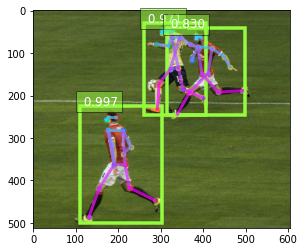

In [17]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs, scores,
                              box_thresh=0.5, keypoint_thresh=0.2)
plt.show()